# 1 Author

**Student Name**:  Liu Ruitong
**Student ID**:  210985746

*Hello! Thank you for reading. You can choose to visit my github repo for a better reading experience!: [https://github.com/Alixyvtte/Smile-Face-and-Glasses-Detection]*

# 2 Problem formulation
The machine learning problem that I have designed for this advanced task consists of two main components:

（1）Glasses Detection （2）Putting on a **COOL** pair of sunglasses on the face &#128526;!!!

For Glasses Detection, this is a binary classification problem. The objective is to create a model capable of analyzing facial occlusion in an image and predicting whether the person is wearing glasses or not. For the sunglasses part, we need to further extend the capabilities to include placing a cool pair of sunglasses on the face in an image. This requires detecting facial key points, precisely locating them, and applying a graphical overlay for the sunglasses.

**Then...What's interesting? &#x1F62E;**
* There's a diverse range of glasses types. The challenge lies in data preprocessing methods and the network design.
* Achieving the task of wearing sunglasses!! (This seems akin to facial effects found in **TikTok!!**)


Describe the machine learning problem that you want to solve and explain what's interesting about it.

# 3 Machine Learning pipeline
The proposed Machine Learning pipeline consists of four main parts: 

(1) Dataset Annotation
(2) Data Preprocessing (or transformation) 
(3) Feature Extraction 
(4) Outputs Integration
The following will introduce each stage in detail.

**Input:** Original images

*Stage 1: Dataset Annotation*
As there are no labels indicating whether individuals in the provided genki4k dataset are wearing glasses or not, we require an accurate classifier to label the data for subsequent training of our own recognition network. Here, we utilize get_frontal_face_detector from dlib to label the data.

*Output:* Two files; one stores all the samples wearing glasses, and the other contains samples not wearing glasses

*Stage 2: Data Preprocessing* 
(Same as the base version!! so i just use the picture from base version)
First, in order to obtain higher quality training images with clearer features, I choose to use the pre-trained CascadeClassifier from cv2 to locate and crop the faces in the images and resize the photo for consistency, to eliminate the interference that may exist in the surrounding environment, and delete overly complex images. 

*Output(next input):*   Cropped images, all with the shape of (128x128)

*Stage 3: Feature Extraction*
The model architecture here is derived from the paper *"Robust smile detection using convolutional neural networks"*, which has demonstrated state-of-the-art (SOTA) performance in some image detection tasks. Moreover, it is lightweight and does not require excessive computational resources.

*Output:*   The trained model and the evaluation matrix on the test set

*Stage 4: Outputs Integration*
I employ a pre-trained glasses detector to analyze the input image and generate output. Additionally, the eyes_cascade.detectMultiScale is used to detect key points for the eyes. Next up... applying cool sunglasses!!! &#128526;

**Output:**  The integrated result image.

# 4 Transformation stage
The transformations used in the proposed method mainly include the data preprocessing and feature extraction stages, and the processes are as follows:

—————————————————— Data Preprocessing ———————————————

***input:***  Origin image with different size

cascade_model.detectMultiScale --> Detected parts position (x, y, width, height)

A region of interest (ROI) is extracted --> Image [y: y + h, x: x + w]

***output:*** A list of cropped images with size (128x128)

*Why I have chosen this method...:* &#x1F615;

Cascade models use a series of classifiers to quickly eliminate non-face regions in an image, making them suitable for our speed requirement. I choose to use this model to crop out accurate face images first, to provide a higher quality training set for the subsequent smile detection task.

————————————————— Feature Extraction —————————————————

***input:***  Cropped images with size (64x64)

BGR image (OpenCV's cvtColor)  --> Grayscale image

Grayscale image --> NumPy array --> Make it between 0 to 1

***output:*** A list of NumPy array

*Why I have chosen this method...:* &#x1F615;

Converting the image to grayscale simplifies the representation by reducing the number of channels from three (RGB) to one, which makes it computationally more efficient for smile detection and feature extraction. NumPy arrays provide a standardized format for image data, making them suitable for inputting into the next proposed networks.

# 5 Modelling
The ML models I used are from the paper *"Robust smile detection using convolutional neural networks"*, the architecture setup is as follows:

*Input Layer:*

The model expects input images with a shape of (imgRows, imgCols, numChannels)

*Convolutional Layers:*

Two sets of Convolutional => Activation => Pooling layers:
First set: 32 filters, kernel size 3x3, "same" padding, and ReLU activation.
MaxPooling layer with a 2x2 pool size and 2x2 strides.
Batch Normalization.
Second set: 32 filters, kernel size 5x5, "same" padding, and ReLU activation.
AveragePooling layer with a 2x2 pool size and 2x2 strides.
Batch Normalization.
Third set: 64 filters, kernel size 5x5, "same" padding, and ReLU activation.
AveragePooling layer with a 2x2 pool size and 2x2 strides.

*Fully Connected (FC) Layers:*

Flattening layer to reduce the output to a 256-dimensional vector.
A Dense layer with 2 units and softmax activation, suitable for binary classification.

*Why I have chosen this model...:* &#x1F603;
According to the paper, the network involves the detection of faces using a multiview face detector, aligning facial images using an eye-based approach, and predicting whether it is a smiling face or not using an ad hoc designed CNN. The study explored the robustness of the method to various geometric transformations (rotation, translation, and scaling) and several types of distortions (JPEG compression, Gaussian noise, Gaussian blur, and motion blur), all of which demonstrated commendable detection performance. Therefore, I believe that the network is likely to exhibit excellent performance in the task of glasses recognition.

# 6 Methodology
**Dataset Setup:**

Data split ratio: train:validate = 4:1; train:test = 4:1. The data was shuffled before partitioning.

**Training & Testing Setup:**

During training, binary crossentropy is used as the loss function for the glasses detection task, and employed the Adam optimizer and accuracy as the metric. The model achieved the best performance (the final models used for testing) with batch_size = 32 and epochs = 8, leveraging a Tesla T4 GPU.

For testing, configured the batch_size as 64 and employed the classification_report to showcase the model's performance on the test set. This report offers a comprehensive analysis, presenting metrics such as precision, recall, and F1-score for each class.

In [1]:
import numpy as np
import dlib
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import statistics
from enum import Enum
import os
import dlib
from keras.preprocessing.image import img_to_array

# 7 Dataset

The **GENKI4** dataset is an image database that contains facial expressions spanning a wide range of illumination conditions, personal identity, and ethnicity. It consists of 4000 face images, each labeled with smile content (1=smile, 0=non-smile) and head pose (yaw, pitch, and roll parameters, in radians).

The following represents the dataset Annotation and data preprocessing process, along with the visualization of some raw data samples and data after preprocessing.

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/genki4k/shape_predictor_81_face_landmarks.dat')

In [3]:
def glasses_detector(path):

    img = dlib.load_rgb_image(path)

    if len(detector(img))==0:
        return('No face detected')
    rect = detector(img)[0]
    sp = predictor(img, rect)
    landmarks = np.array([[p.x, p.y] for p in sp.parts()])

    nose_bridge_x = []
    nose_bridge_y = []

    for i in [28,29,30,31,33,34,35]:
        nose_bridge_x.append(landmarks[i][0])
        nose_bridge_y.append(landmarks[i][1])

    ### x_min and x_max
    x_min = min(nose_bridge_x)
    x_max = max(nose_bridge_x)

    ### ymin (from top eyebrow coordinate),  ymax
    y_min = landmarks[20][1]
    y_max = landmarks[30][1]

    img2 = Image.open(path)
    img2 = img2.crop((x_min,y_min,x_max,y_max))

    img_blur = cv2.GaussianBlur(np.array(img2),(3,3), sigmaX=0, sigmaY=0)

    edges = cv2.Canny(image =img_blur, threshold1=100, threshold2=200)

    edges_center = edges.T[(int(len(edges.T)/2))]

    if 255 in edges_center:
        return(1)
    else:
        return(0)

# Let's see how this detector performs...

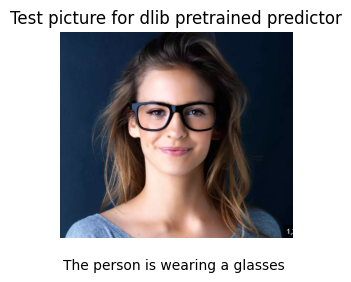

In [4]:
path = '/content/drive/MyDrive/genki4k/glasses.png'
img = dlib.load_rgb_image(path)
# Display the original and result images using matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.title("Test picture for dlib pretrained predictor")
plt.axis("off")
if glasses_detector(path)==1:
  plt.text(0.5, -0.15, "The person is wearing a glasses ", ha='center', transform=plt.gca().transAxes)
else:
  plt.text(0.5, -0.15, "The person is not wearing a glasses ", ha='center', transform=plt.gca().transAxes)

pretty good actually! Then we do annotation on genki4k!

In [5]:
# Generate labels for all images using a pre-trained model
import os

def process_folder(folder_path, output_folder_glasses, output_folder_no_glasses):
    # Create output folders if they do not exist
    os.makedirs(output_folder_glasses, exist_ok=True)
    os.makedirs(output_folder_no_glasses, exist_ok=True)

    # Iterate over each file in the specified folder
    for filename in os.listdir(folder_path):
        # Check if the file is a JPEG image
        if filename.endswith(".jpg"):
            # Build the full path to the image file
            image_path = os.path.join(folder_path, filename)

            # Use the pre-trained model to detect glasses in the image
            result = glasses_detector(image_path)

            # Read the image using OpenCV
            image = cv2.imread(image_path)

            # Save the image to the appropriate output folder based on the detection result
            if result == 1:
                output_path = os.path.join(output_folder_glasses, filename)
                cv2.imwrite(output_path, image)
            else:
                output_path = os.path.join(output_folder_no_glasses, filename)
                cv2.imwrite(output_path, image)

# Replace with the actual folder paths and output folder paths
input_folder = "/content/drive/MyDrive/genki4k/files"
output_folder_glasses = "/content/drive/MyDrive/genki4k/output_images_glasses"
output_folder_no_glasses = "/content/drive/MyDrive/genki4k/output_images_no_glasses"

# Call the function to process the folder
process_folder(input_folder, output_folder_glasses, output_folder_no_glasses)


In [7]:
samples_glasses = os.listdir(output_folder_glasses)
samples_no_glasses = os.listdir(output_folder_no_glasses)
data = []
labels = []

# Check！ They all have glasses!!

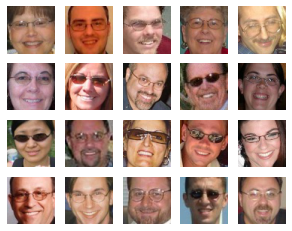

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
folder_path = "/content/drive/MyDrive/genki4k/output_images_glasses"
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg'))]
selected_images = image_files[:20]
plt.figure(figsize=(5, 4))
for i, image_file in enumerate(selected_images, 1):
    plt.subplot(4, 5, i)
    
    image_path = os.path.join(folder_path, image_file)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [8]:
# collect data from samples
for image in samples_glasses:
    img = cv2.imread(os.path.join(output_folder_glasses,image))
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img_to_array(gray)
    data.append(gray)
    labels.append(1)

for image in samples_no_glasses:
    img = cv2.imread(os.path.join(output_folder_no_glasses,image))
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img_to_array(gray)
    data.append(gray)
    labels.append(0)

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 2)
# convert to numpy array and make it between 0 to 1
data = np.array(data, dtype = "float") / 255.0

# 8 Results

The following is the experimental section and results analysis.

# The final accuracy on the test set reached 99% ! &#128513;

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense, BatchNormalization, Dropout, AveragePooling2D
from keras import backend as K
from keras.utils import to_categorical

The model structure

In [12]:
def EyeNet(numChannels, imgRows, imgCols, outputDim, activation="relu", weightsPath=None):
    # Initialize the model
    model = Sequential()
    inputShape = (imgRows, imgCols, numChannels)

    # If we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (numChannels, imgRows, imgCols)

    # MIT formula: (W−F+2P)/S +1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1)))  # Output: 32x32x32
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))  # Output: 16x16x32
    model.add(BatchNormalization())  # LRN layer, using batch normalization instead

    model.add(Conv2D(32, (5, 5), padding='same'))  # Output: 16x16x32
    model.add(AveragePooling2D((2, 2), strides=(2, 2)))  # Output: 8x8x32
    model.add(BatchNormalization())  # LRN layer, using batch normalization instead

    model.add(Conv2D(64, (5, 5), padding='same'))  # Output: 8x8x64
    model.add(AveragePooling2D((2, 2), strides=(2, 2)))  # Output: 4x4x64

    model.add(Flatten())  # Flatten to a 256-dimensional vector

    model.add(Dense(2))  # Fully connected layer, output is a 2-dimensional vector
    model.add(Activation('softmax'))  # Activation layer, using softmax function

    # If a weights path is supplied (indicating that the model was pre-trained), then load the weights
    if weightsPath is not None:
        model.load_weights(weightsPath)

    # Return the constructed network architecture
    return model


The partitioning of the dataset and the configuration of certain model hyperparameters.

In [32]:
# get model ready
# partition the data into training and testing splits using 80% of the data
# for training and remaining 20% for testing
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

# initialize the model
print("[INFO] compiling model...")
model = EyeNet(numChannels = 1, imgRows = 128, imgCols = 128, outputDim = 2)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])


[INFO] compiling model...


**Model Details**

In [33]:
# print the summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        25632     
                                                                 
 average_pooling2d_10 (Aver  (None, 32, 32, 32)        0         
 agePooling2D)                                                   
                                                      

**Model Training Process**

In [34]:
print("[INFO] training network for galssses recognition...")
out = model.fit(trainX, trainY, validation_data = (testX, testY), batch_size = 32, epochs = 8, verbose=1)

[INFO] training network for galssses recognition...
Epoch 1/8
31/31 [==============================] - 48s 1s/step - loss: 0.2720 - accuracy: 0.9062 - val_loss: 0.4317 - val_accuracy: 0.9677
Epoch 2/8
31/31 [==============================] - 47s 2s/step - loss: 0.0682 - accuracy: 0.9778 - val_loss: 0.6953 - val_accuracy: 0.6210
Epoch 3/8
31/31 [==============================] - 46s 1s/step - loss: 0.0325 - accuracy: 0.9899 - val_loss: 0.3263 - val_accuracy: 0.9395
Epoch 4/8
31/31 [==============================] - 45s 1s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.9718
Epoch 5/8
31/31 [==============================] - 47s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2226 - val_accuracy: 0.9960
Epoch 6/8
31/31 [==============================] - 58s 2s/step - loss: 8.4704e-04 - accuracy: 1.0000 - val_loss: 0.1989 - val_accuracy: 0.9960
Epoch 7/8
31/31 [==============================] - 57s 2s/step - loss: 3.7723e-04 - accuracy: 1.0000 - val_los

**Model Testing Process**

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1)))
# Save the model to disk
model.save("Glasses.h5")

[INFO] evaluating network...
4/4 [==============================] - 3s 877ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       0.99      1.00      1.00       154

    accuracy                           1.00       248
   macro avg       1.00      0.99      1.00       248
weighted avg       1.00      1.00      1.00       248


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Design a function to receive a new photo, determine whether there is a glasses.**

In [68]:
def detect_glasses(frame, model_glasses):

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    gray_1 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_1, 1.3, 5)

    img = cv2.resize(frame, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sample = img_to_array(gray)
    sample = np.array(sample, dtype = "float") / 255.0
    data = []
    data.append(sample)
    data = np.array(data)

    # predict using model and find the best match
    predictions_glasses = model_glasses.predict(data)

    label = "Glasses!!" if predictions_glasses[0][1] > predictions_glasses[0][0] else "No Glasses"
    if predictions_glasses[0][1] > predictions_glasses[0][0]:
      result="This person is wearing glasses!!!"
    else:
      result="This person is NOT wearing glasses"
    i = 0
    for (x,y,w,h) in faces:
      cv2.rectangle(frame, (x, y), (x+w, y+h), (255,0,0), 2)
      i = i + 1
      cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 1, cv2.LINE_AA)
      roi_gray = gray[y:y+h, x:x+w]
      roi_color = frame[y:y+h, x:x+w]
      eyes = eye_cascade.detectMultiScale(roi_gray)
      for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

    return frame, result

# Let's do some testing!!... &#128515;

1/1 [==============================] - 0s 113ms/step


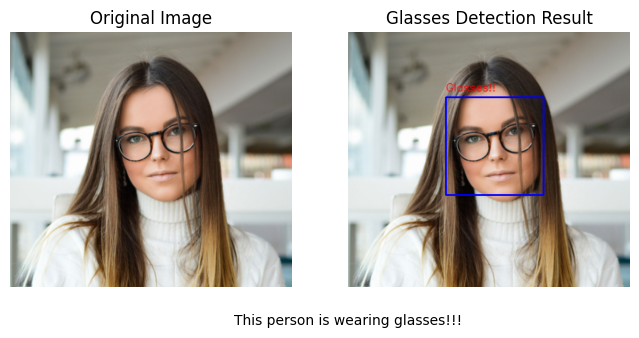

In [69]:
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

image_path_1 = '/content/drive/MyDrive/genki4k/999.png'

model_glasses_path = '/content/Glasses.h5'

# Load the pre-trained LeNet model
model_glasses = tf.keras.models.load_model(model_glasses_path)

# Load the image
image_1 = cv2.imread(image_path_1)

# Call detect_glasses to perform glasses detection
result_image_1, text1 = detect_glasses(image_1, model_glasses)
# Display the original and result images using matplotlib
plt.figure(figsize=(8, 8))
image_1 = Image.open(image_path_1)
plt.subplot(1, 2, 1)
plt.imshow(image_1)
plt.title("Original Image")
plt.axis("off")

# Display result image 1
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_image_1, cv2.COLOR_BGR2RGB))
plt.title("Glasses Detection Result")
plt.axis("off")
plt.text(0.0, -0.15, str(text1), ha='center', transform=plt.gca().transAxes)


plt.show()


**Above is a picture with glasses. You can see that the top-left corner label of the blue box is "Glasses!!".**

In [77]:
from google.colab.patches import cv2_imshow
def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Function to resize the image while maintaining the aspect ratio
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

# Read the image to be processed
input_image_path = '/content/drive/MyDrive/genki4k/zhao.png'
frame = cv2.imread(input_image_path)

# Load Haar cascade classifiers for face and eyes detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/genki4k/frontalEyes35x16.xml')

# Load glasses image with an alpha channel
glasses = cv2.imread("/content/drive/MyDrive/genki4k/cool_glasses.png", -1)

# Convert the frame to grayscale for face and eyes detection
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale frame
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)

# Iterate through detected faces
for (x, y, w, h) in faces:
    # Extract the region of interest (ROI) for face
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]

    # Detect eyes in the face ROI
    eyes = eyes_cascade.detectMultiScale(roi_gray, scaleFactor=1.5, minNeighbors=5)

    # Iterate through detected eyes
    for (ex, ey, ew, eh) in eyes:
        # Extract the ROI for eyes
        roi_eyes = roi_gray[ey: ey + eh, ex: ex + ew]

        # Resize the glasses image to fit the width of the detected eyes
        glasses_resized = image_resize(glasses.copy(), width=ew)

        # Overlay the resized glasses on the frame
        gw, gh, _ = glasses_resized.shape  # Remove the 'c' variable as it's not needed
        for i in range(gw):
            for j in range(gh):
                if glasses_resized[i, j][3] != 0:  # Check alpha channel (transparency)
                    roi_color[ey + i, ex + j, :] = glasses_resized[i, j, :3]  # Assign RGB values


**Something interesting...**
This is the glasses we are going to use!

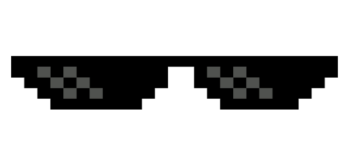

In [6]:
import matplotlib.image as mpimg
image_path = 'D:\PyCharm\PycharmProjects\CBU5201\MiniProject\cool_glasses (1).png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Do some cool things... &#128521;
**Let's add sunglasses to the handsome gentleman below!**

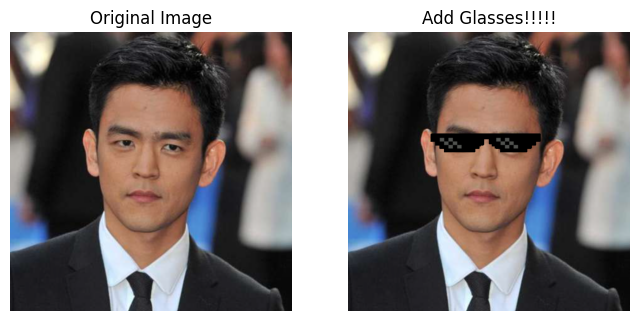

In [78]:
# Let's see what's happen!!!
plt.figure(figsize=(8, 8))
image_1 = Image.open(input_image_path)
plt.subplot(1, 2, 1)
plt.imshow(image_1)
plt.title("Original Image")
plt.axis("off")
# Display the final processed image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Add Glasses!!!!!")
plt.axis("off")
plt.show()

# 9 Conclusions
This project proposes a machine learning pipeline for detecting glasses and put a cool sunglasses on a face. The backbone network is based on EyeNet, a lightweight architecture proposed by a paper. The model architecture has been fine-tuned for specific binary classification tasks. During the data annotation stage, a robust pre-trained detector was employed for annotating the dataset. In the data preprocessing stage, the advantages of pre-trained models are leveraged for image cropping. After only **8** epochs of training, the model achieves an overall remarkably accuracy of **99%** on the test set.

For further improvements, we can explore adding real-time facial effects to videos or expanding into the detection and addition of other facial decorations. That would be much more fun! &#128521;

**Thanks for your reading !! &#128512;**